In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np

from sklearn.model_selection import train_test_split

import xgboost as xgb
import shap

In [2]:
RANDOM_STATE = 42

data = pd.read_excel('../data/fraud.xlsx')
# Data Cleaning Steps
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'], errors='coerce')
data['dob'] = pd.to_datetime(data['dob'], errors='coerce')
data['is_fraud'] = data['is_fraud'].astype(str).str.replace('1"2020-12-24 16:56:24"', '1')
data['is_fraud'] = data['is_fraud'].str.replace('0"2019-01-01 00:00:44"', '0')
data['is_fraud'] = data['is_fraud'].astype(int)
data['merchant'] = data['merchant'].str.replace(r'^"|"$', '', regex=True)
data['job'] = data['job'].str.replace(r'^"|"$', '', regex=True)
data = data.drop_duplicates(subset='trans_num', keep='first')
data = data.sort_values(by='trans_date_trans_time')
data['merchant'] = data['merchant'].astype('category')
data['category'] = data['category'].astype('category')
data['city'] = data['city'].astype('category')
data['state'] = data['state'].astype('category')
data['job'] = data['job'].astype('category')
data['is_fraud'] = data['is_fraud'].astype('category')
data['trans_num'] = data['trans_num'].astype('category')

In [3]:
X = data.drop(columns=['trans_num'])
y = data['is_fraud']

X['trans_year'] = X['trans_date_trans_time'].dt.year.astype('category')
X['trans_month'] = X['trans_date_trans_time'].dt.month.astype('category')
X['trans_day_of_month'] = X['trans_date_trans_time'].dt.day.astype('category')
X['trans_day_of_week'] = X['trans_date_trans_time'].dt.day_of_week.astype('category')
X['trans_day_of_year'] = X['trans_date_trans_time'].dt.day_of_year.astype('category')
X['trans_hour'] = X['trans_date_trans_time'].dt.hour.astype('category')
X['trans_time_to_second'] = (
    X['trans_date_trans_time'].dt.hour*3600 + 
    X['trans_date_trans_time'].dt.minute*60 + 
    X['trans_date_trans_time'].dt.second
)
X['cust_age'] = (X['trans_date_trans_time'] - data['dob']).dt.days // 365
X['trans_time_sin'] = np.sin(2 * np.pi * X['trans_time_to_second'] / 86400)
X['trans_time_cos'] = np.cos(2 * np.pi * X['trans_time_to_second'] / 86400)
X['distance'] = X.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).meters, axis=1)

X.drop(columns=['merch_lat', 'merch_long', 'lat', 'long', 'trans_date_trans_time', 'dob', 'is_fraud'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

full_DM = xgb.DMatrix(X, label=y, enable_categorical=True)
train_DM = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
test_DM = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [4]:
params = {
    'objective': 'binary:logistic',
    'seed': RANDOM_STATE,
    'eval_metric': 'aucpr',
    'eta': 0.01,
}

score = xgb.cv(params, full_DM, nfold=5, num_boost_round=10000, early_stopping_rounds=100, verbose_eval=100)


[0]	train-aucpr:0.99477+0.00143	test-aucpr:0.98854+0.00593
[100]	train-aucpr:0.99881+0.00055	test-aucpr:0.99392+0.00403
[200]	train-aucpr:0.99976+0.00007	test-aucpr:0.99725+0.00151
[300]	train-aucpr:0.99998+0.00001	test-aucpr:0.99851+0.00084
[400]	train-aucpr:1.00000+0.00000	test-aucpr:0.99857+0.00105
[500]	train-aucpr:1.00000+0.00000	test-aucpr:0.99885+0.00095
[600]	train-aucpr:1.00000+0.00000	test-aucpr:0.99905+0.00091
[700]	train-aucpr:1.00000+0.00000	test-aucpr:0.99924+0.00076
[800]	train-aucpr:1.00000+0.00000	test-aucpr:0.99934+0.00069
[900]	train-aucpr:1.00000+0.00000	test-aucpr:0.99946+0.00061
[1000]	train-aucpr:1.00000+0.00000	test-aucpr:0.99953+0.00056
[1100]	train-aucpr:1.00000+0.00000	test-aucpr:0.99954+0.00054
[1200]	train-aucpr:1.00000+0.00000	test-aucpr:0.99957+0.00052
[1300]	train-aucpr:1.00000+0.00000	test-aucpr:0.99958+0.00050
[1400]	train-aucpr:1.00000+0.00000	test-aucpr:0.99959+0.00049
[1500]	train-aucpr:1.00000+0.00000	test-aucpr:0.99962+0.00045
[1600]	train-aucpr:1

In [8]:
bst = xgb.train(params, train_DM, num_boost_round=100000, evals=[(test_DM, 'test')], early_stopping_rounds=100, verbose_eval=100)

[0]	test-aucpr:0.98625
[100]	test-aucpr:0.99365
[200]	test-aucpr:0.99620
[300]	test-aucpr:0.99770
[400]	test-aucpr:0.99830
[500]	test-aucpr:0.99841
[600]	test-aucpr:0.99887
[700]	test-aucpr:0.99912
[800]	test-aucpr:0.99932
[900]	test-aucpr:0.99941
[1000]	test-aucpr:0.99954
[1100]	test-aucpr:0.99962
[1200]	test-aucpr:0.99966
[1293]	test-aucpr:0.99966


In [9]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer(test_DM)

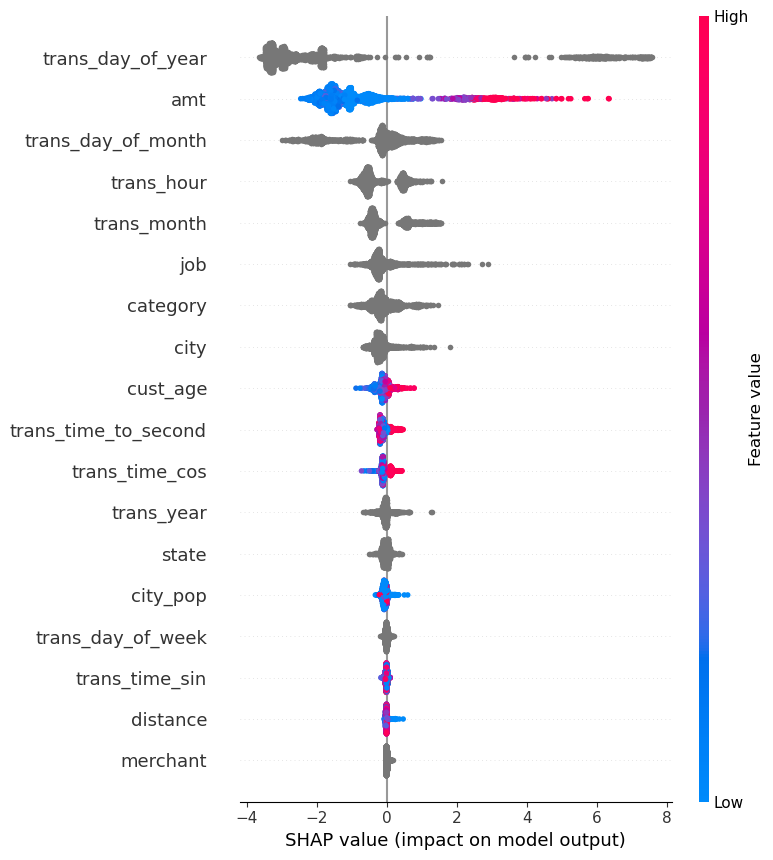

In [12]:
shap.summary_plot(shap_values, X_test)

In [17]:
prediction = bst.predict(test_DM)
prediction = (prediction > 0.5).astype(int)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2521
           1       1.00      0.99      0.99       356

    accuracy                           1.00      2877
   macro avg       1.00      0.99      1.00      2877
weighted avg       1.00      1.00      1.00      2877

